# 데이터 획득

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# 모듈
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gridspec
from sklearn import metrics
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder
from sklearn.metrics import roc_auc_score, confusion_matrix, accuracy_score, recall_score, precision_score, f1_score, classification_report, roc_curve
from scipy import sparse
import xgboost as xgb
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

%matplotlib inline

In [ ]:
# 데이터 가져오기 
data_path = '/content/drive/MyDrive/모듈프젝2/B팀-분류/data/playground-series-season-3-episode-2/'

train = pd.read_csv(data_path + 'train.csv', index_col='id')
test = pd.read_csv(data_path + 'test.csv', index_col='id')
submission = pd.read_csv(data_path + 'sample_submission.csv', index_col='id')
# 원본 데이터 
original = pd.read_csv(data_path + 'healthcare-dataset-stroke-data.csv', index_col='id')

train

FileNotFoundError: ignored

In [ ]:
original

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
id,,,,,,,,,,,
9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...
18234,Female,80.0,1,0,Yes,Private,Urban,83.75,NaN,never smoked,0
44873,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.0,never smoked,0
19723,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.6,never smoked,0


#데이터 준비 + EDA(분석, 피처 엔지니어링 대상 및 처리내용 체크)

## 데이터 및 결측치 확인

In [ ]:
train.head().T

id,0,1,2,3,4
gender,Male,Male,Female,Male,Female
age,28.0,33.0,42.0,56.0,24.0
hypertension,0,0,0,0,0
heart_disease,0,0,0,0,0
ever_married,Yes,Yes,Yes,Yes,No
work_type,Private,Private,Private,Private,Private
Residence_type,Urban,Rural,Rural,Urban,Rural
avg_glucose_level,79.53,78.44,103.0,64.87,73.36
bmi,31.1,23.9,40.3,28.8,28.8
smoking_status,never smoked,formerly smoked,Unknown,never smoked,never smoked


- 데이터 확인 내용




```

'gender', : Male, Female, other로 구성됨 
            - other의 개수 1개로 확인됨
'age', : 나이 /  수치형
'hypertension',  : 고혈압 유무 / 0 : 무, 1 : 유 => 이진형
'heart_disease', : 심장질환 유무 / 0 : 무, 1 : 유 => 이진형
'ever_married', : 결혼 유무 / Y : 기혼, N : 미혼 => 이진형
'work_type', : 업무형태 / 'Private', 'children', 'Govt_job', 'Self-employed', 'Never_worked' => 명목형
'Residence_type', : 거지 /  Urban, Rural / 도시, 시골 => 이진형
'avg_glucose_level', 평균 당 수치 / 수치형 
'bmi', : 비만도 / 수치형
'smoking_status', : 흡연상태  / 'never smoked', 'formerly smoked', 'Unknown', 'smokes' => 명목형
'stroke' : 뇌졸중 유무 / 0 : 무, 1 : 유  => 정답
```






In [ ]:
# 고유값 갯수 확인
train.nunique().values, test.nunique().values, submission.nunique().values

(array([   3,  106,    2,    2,    2,    5,    2, 3740,  407,    4,    2]),
 array([   3,  106,    2,    2,    2,    5,    2, 3265,  400,    4]),
 array([1]))

In [ ]:
# train, test, submission 인덱스 확인
train.columns, test.columns, submission.columns

(Index(['gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
        'work_type', 'Residence_type', 'avg_glucose_level', 'bmi',
        'smoking_status', 'stroke'],
       dtype='object'),
 Index(['gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
        'work_type', 'Residence_type', 'avg_glucose_level', 'bmi',
        'smoking_status'],
       dtype='object'),
 Index(['stroke'], dtype='object'))

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15304 entries, 0 to 15303
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             15304 non-null  object 
 1   age                15304 non-null  float64
 2   hypertension       15304 non-null  int64  
 3   heart_disease      15304 non-null  int64  
 4   ever_married       15304 non-null  object 
 5   work_type          15304 non-null  object 
 6   Residence_type     15304 non-null  object 
 7   avg_glucose_level  15304 non-null  float64
 8   bmi                15304 non-null  float64
 9   smoking_status     15304 non-null  object 
 10  stroke             15304 non-null  int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 1.4+ MB


In [ ]:
original.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5110 entries, 9046 to 44679
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             5110 non-null   object 
 1   age                5110 non-null   float64
 2   hypertension       5110 non-null   int64  
 3   heart_disease      5110 non-null   int64  
 4   ever_married       5110 non-null   object 
 5   work_type          5110 non-null   object 
 6   Residence_type     5110 non-null   object 
 7   avg_glucose_level  5110 non-null   float64
 8   bmi                4909 non-null   float64
 9   smoking_status     5110 non-null   object 
 10  stroke             5110 non-null   int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 479.1+ KB


In [ ]:
# original 결측값 확인됨
train.isnull().sum().values, test.isnull().sum().values,submission.isnull().sum().values, original.isnull().sum().values

(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 array([0]),
 array([  0,   0,   0,   0,   0,   0,   0,   0, 201,   0,   0]))

In [ ]:
# bmi 항목 결측치 확인 => 결측치 해결 검토 
original.isna().sum()

gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

In [ ]:
test.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status
id,,,,,,,,,,
15304,Female,57.0,0,0,Yes,Private,Rural,82.54,33.4,Unknown
15305,Male,70.0,1,0,Yes,Private,Urban,72.06,28.5,Unknown
15306,Female,5.0,0,0,No,children,Urban,103.72,19.5,Unknown
15307,Female,56.0,0,0,Yes,Govt_job,Urban,69.24,41.4,smokes
15308,Male,32.0,0,0,Yes,Private,Rural,111.15,30.1,smokes


In [ ]:
submission.head()
# submossion의 stroke 기본값 0.041296

,stroke
id,
15304,0.041296
15305,0.041296
15306,0.041296
15307,0.041296
15308,0.041296


In [ ]:
# test.id = submission id 
train.shape, test.shape, submission.shape

((15304, 11), (10204, 10), (10204, 1))

- test, submission의 id 동일함
- 정답인 stroke는 test 데이터에는 없음 / train, submission에만 존재함
- original파일의 bmi 항목 결측값 확인됨

## 시각화를 통한 정답값 분포 확인

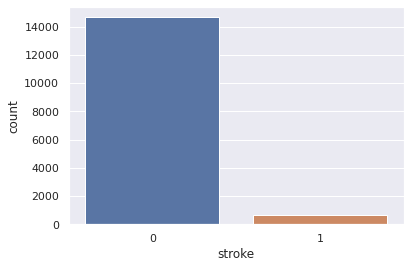

In [ ]:
# stroke 값 확인
# 뇌졸중을 가진 사람보다 뇌졸중이 아닌 사람이 많음 
sns.countplot(data=train, x='stroke');

In [ ]:
c0, c1 = np.unique( train.stroke.values, return_counts=True)[1]
c0 / c1 
# 0이 1보다 23.21518987341772배 많음 => 뇌졸중 환자보다 뇌졸중 환자가 아닌 사람이 23.21518987341772배 많음

23.21518987341772

타겟값간 비율 23.21518987341772


Text(0.5, 1.0, 'Stroke Value Distribution')

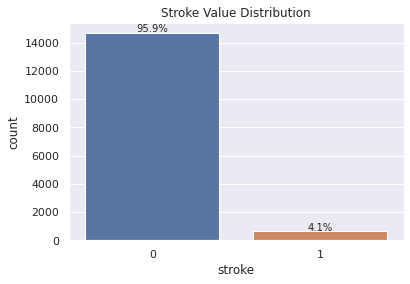

In [ ]:
# 향후 시각화 자료에 비율을 표기하는 부분을 추가 => 텍스트 드로잉
def show_text_percent_by_stroke( ax, total_count, is_show=True,  ):
  '''
    is_show : True일때만 텍스트가 노출되게 처리
    ax : 텍스트를 그리고자 하는 차트의 축정보
    total_count : 전체 카운트수
  '''
  persents = list()         # 비율을 담는 그릇
  # 카운트 플롯 차트상에 개별 박스 정보를 구하는 방법 -> ax.patches

  # 카운트 플롯 차트상에서 순차적으로 박스를 하나씩 추출한다
  for patch in ax.patches: # 차트상에 존재하는 모든 형태의 도형을 차례대로 추출하는 연속형 변수
    w = patch.get_width()  # 타겟값 0 혹은 1, 카운트 플롯의 개별 박스 너비
    h = patch.get_height() # 타겟값 0 혹은 1의 카운트수 -> 카운트 플롯의 개별 박스 높이->카운트
    p = h/total_count * 100 # 타깃값의 비율 = (개별박스의 높이(카운트) / 전체카운트)*100
    persents.append( p )
    # 텍스트 그리기
    # 좌표 정보 획득
    l = patch.get_x()    # 도형 왼쪽 테투리 X축의 기준 위치값    
    ax.text(  x=l + w/2,  # 도형의 정 가운데를 X축 좌표
              y=h + total_count*0.005, # 1, total_count(가변값)의 특정 비율로 올려서 위치를 조정
              s=f'{p:1.1f}%', # 타겟값의 비율을 개별 차트내 도형 위에 그려지는 내용 ex) 38.8% /  현 차트 내에 69.4%, 30.6% 임
              ha='center'    # 정렬(가운데)
            )
  if is_show:
    if len(persents) == 2: # 타겟용
      print( '타겟값간 비율', persents[0]/persents[1] )
    elif len(persents) == 4: # 이진 피처용
      # print(persents)
      # 타겟값에 맞춰서 도형이 그려진다 0번 타겟이 먼저 그려지고, 1번 타겟이 나중에 그려진다
      print( persents[0]/persents[2], persents[1]/persents[3] )
  pass

ax = sns.countplot( data=train, x='stroke');
show_text_percent_by_stroke( ax, train.shape[0] )
ax.set_title('Stroke Value Distribution')

- 정답 값 중 0(뇌졸중 무) : 95.9% 를 차지하고 있음
- 정답 값 중 0(뇌졸중 유) : 4.1% 를 차지하고 있음

##데이터 분석

- 수치형
  - age
  - avg_glucose_level
  -bmi
- 명목형
  - 이진형
    - hypertension
    - heart_disease
    - Residence_type
    - ever_married
  - 고유값 2개 초과
    - gender
    - work_type
    - smoking_status

In [ ]:
# 수치형, 명목형, 명목형 하 이진형 및 이외 항목으로 세분화해서 지정해둠
# 수치형
num_cols = ['age', 'avg_glucose_level', 'bmi'] 
# 명목형
cat_cols = ['gender', 'hypertension','heart_disease', 'Residence_type', 'work_type', 'smoking_status'] 
# 명목형을 고유값 개수에 따라 세부 분류함
cat_cols_v0 = ['gender'] # gender만 따로 진행한 이유는 male, female, other로 고유값 3개로 확인되어 따로 지정해둠 
cat_cols_v1 = ['hypertension','heart_disease', 'Residence_type', 'ever_married']
cat_cols_v2 = ['work_type', 'smoking_status']

In [ ]:
train.dtypes

gender                object
age                  float64
hypertension           int64
heart_disease          int64
ever_married          object
work_type             object
Residence_type        object
avg_glucose_level    float64
bmi                  float64
smoking_status        object
stroke                 int64
dtype: object

### 수치형

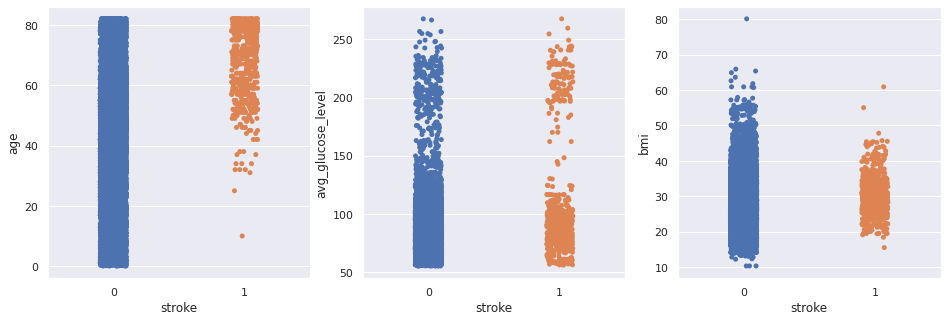

In [ ]:
# 수치형 데이터 시각화 
plt.figure(figsize=(16, 5))
plt.subplot(1, 3,1)
sns.stripplot(data=train, x='stroke', y='age' )
plt.subplot(1, 3,2)
sns.stripplot(data=train, x='stroke', y='avg_glucose_level')
plt.subplot(1, 3,3)
sns.stripplot(data=train, x='stroke', y='bmi')

- 나이 :뇌졸중 환자 중  40~60대 많음
- 평균 당수치 : 뇌졸중 환자 중 당 수치가 높은 사람보다 낮은 사람이 많다 => 당수치와의 상관관계는 적은 것으로 예상됨
- bmi : 뇌졸중 환자의 bmi 수치는 약 20 ~ 40에 분포되어 있으나 뇌졸중 환자가 아닌 사람 또한 비슷한 구간에 분표되어 있어 변별력은 없을 것이라고 예상됨

### 명목형

- 이진형
  - hypertension
  - heart_disease
  - Residence_type
  - ever_married
- 고유값 2개 초과
  - gender
  - work_type
  - smoking_status

### 고유값 2개 이상

In [ ]:
train['gender'].unique()
# 'Male', 'Female', 'Other' 존재함

array(['Male', 'Female', 'Other'], dtype=object)

In [ ]:
train['gender'].value_counts()
# 'other'이 1개 존재함

Female    9446
Male      5857
Other        1
Name: gender, dtype: int64

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


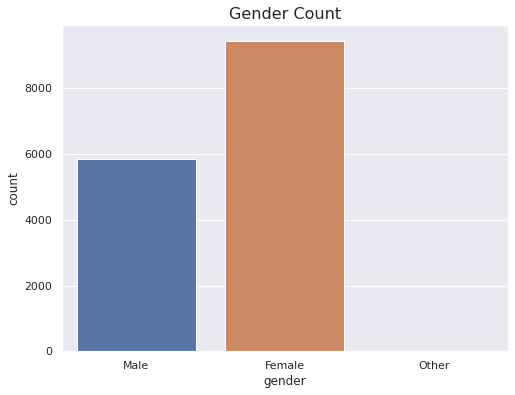

In [ ]:
# gender의 개수 시각화 
# 데이터 중 남성보다 여성이 높다 
plt.figure(figsize=(8, 6))

ax = sns.countplot(train['gender'])
ax.set_title('Gender Count', fontdict={'fontsize': 16})
plt.show()

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


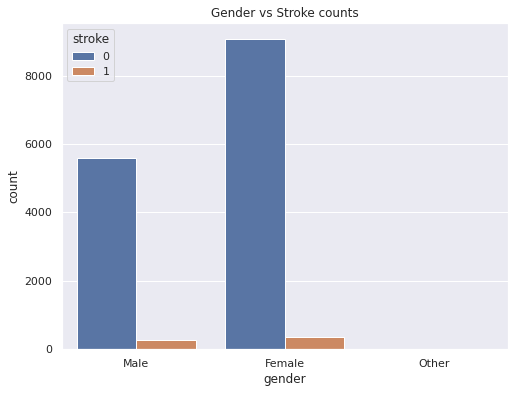

In [ ]:
# gender별 뇌졸중 유무 시각화 
plt.figure(figsize=(8, 6))
ax = sns.countplot(train['gender'], hue=train['stroke'])
ax.set_title('Gender vs Stroke counts')
plt.show()

In [ ]:
# gender 교차분석표 작성
def make_cross_tab(df, id ):
  cross_tab = pd.crosstab( df[id], df['stroke'], normalize='index' ) *100
  cross_tab.reset_index(inplace=True)
  return cross_tab

cross_tab_v1 = make_cross_tab(train, 'gender') 
cross_tab_v1

stroke,gender,0,1
0,Female,96.104171,3.895829
1,Male,95.492573,4.507427
2,Other,100.000000,0.000000


- Female 중 약 3.89%, Male 중 약 4.50%가 뇌졸중 환자로 확인됨
- other은 1명 존재하며 뇌졸중 환자가 아님

In [ ]:
# work_type 고유값 확인
train['work_type'].unique()

array(['Private', 'Self-employed', 'Govt_job', 'children', 'Never_worked'],
      dtype=object)

In [ ]:
# work_type 고유값별 개수 확인
train['work_type'].value_counts()

Private          9752
children         2038
Self-employed    1939
Govt_job         1533
Never_worked       42
Name: work_type, dtype: int64

In [ ]:
# work_type 교차분석표
cross_tab_v2 = make_cross_tab(train, 'work_type') 
cross_tab_v2

stroke,work_type,0,1
0,Govt_job,95.499022,4.500978
1,Never_worked,100.000000,0.000000
2,Private,95.857260,4.142740
3,Self-employed,91.851470,8.148530
4,children,99.950932,0.049068


In [ ]:
# smoking_status 고유값 확인
train['smoking_status'].unique()

array(['never smoked', 'formerly smoked', 'Unknown', 'smokes'],
      dtype=object)

In [ ]:
# smoking_status 고유값별 개수 확인
train['smoking_status'].value_counts()

never smoked       6281
Unknown            4543
formerly smoked    2337
smokes             2143
Name: smoking_status, dtype: int64

In [ ]:
# smoking_status 교차분석표
cross_tab_v3 = make_cross_tab(train, 'smoking_status') 
cross_tab_v3

stroke,smoking_status,0,1
0,Unknown,97.622716,2.377284
1,formerly smoked,93.196406,6.803594
2,never smoked,95.908295,4.091705
3,smokes,94.960336,5.039664


In [ ]:
# cat_cols_v2 = ['work_type', 'smoking_status']
def show_pointplot(id,cross_tab, color, ax=None):
  if ax:
    sns.pointplot( x= id ,            # 피처값
                  y= 1,            # 정답 1에 대한 포인트 플롯
                  data=cross_tab,  # 그리는 대상 df 
                  order= cross_tab[id],          # 포인트 플롯 순서 
                  color=color,     # 그리는 색상
                  ax=ax
                  );
show_pointplot_v2 = show_pointplot('work_type', cross_tab_v2, 'blue')
show_pointplot_v3 = show_pointplot('smoking_status', cross_tab_v2, 'blue')
# nom_0에 설정된 사용하는 고유값 별로 1의 비율이 다르다 -> 구분된다 -> 학습에 도움된다 

0.723292469352014 1.0905272981801213


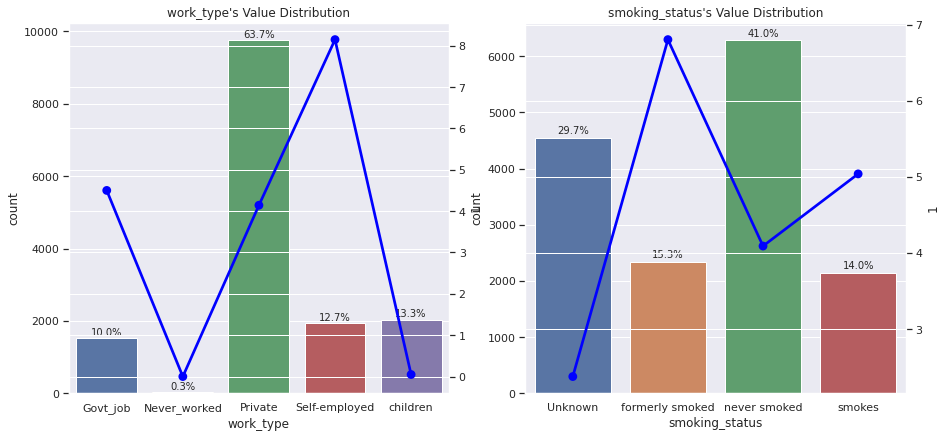

In [ ]:
# cat_cols_v2 = ['work_type', 'smoking_status']
def show_count_point_plot( all_data, features, rows=2, cols=2): 
  # 1개의 차트에 격자로 분할 -> 각 자리에 ax를 전달 -> 이것을 이용하여 그린다 
  plt.figure( figsize=(15,15) ) # 그리면서 조정 : 세로 3칸, 가로 2칸
  # 서브플롯 배치 
  p_grid = gridspec.GridSpec(rows, cols) # 3줄, 2칸 => 차트 5개 ;=> 피처가 5개

  for idx, feature in enumerate( features ):
    ax = plt.subplot(p_grid[idx])
    cross_tab = make_cross_tab(all_data, feature )
      # order를 사용했으면 한 차트에 사용되는 모든 함수는 같은 순서(order) 유지해야 동일하게 배치됨(그렇지 않으면 배치가 달라질 수 있다)
    sns.countplot( data=all_data, x=feature, ax=ax, order=cross_tab[feature] ) # ax=ax : 격자 안에서 특정 위치로 차트가 세팅
    show_text_percent_by_stroke( ax, all_data.shape[0] )
    ax.set_title(f'{feature}\'s Value Distribution')

    
    show_pointplot(feature, cross_tab, 'blue', ax.twinx())

  plt.show()

show_count_point_plot( train, cat_cols_v2)

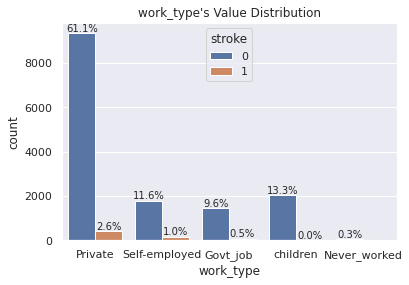

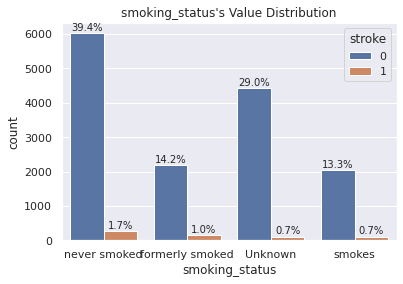

In [ ]:
cat_cols_v2 = ['work_type', 'smoking_status']
for cat_col_v2 in cat_cols_v2:
  ax = sns.countplot( data=train, x=cat_col_v2, hue='stroke');
  show_text_percent_by_stroke( ax, train.shape[0] )
  ax.set_title(f'{cat_col_v2}\'s Value Distribution')
  plt.show()

- 업무 : 총 데이터의 직업 중 가장 많은 비중을 차지하고 있는 직업은 Private work_type이나 뇌졸중 환자가 가장 많은 직업은 Self-employed 
=> 발병 순위는 Self-employed - Govt_job - Private_work_type - Never_worked - children 
- 흡연 : 총 데이터 중 담배를 전혀 피지 않았던 사람의 비율이 높음. 뇌졸중 환자는 전에 흡연을 했던 사람의 비율이 높음
=> 발병 순위는 fermerly smoked - never smoked  - smokes - Unknown

### 이진형

27.855158730158724 4.945312500000001


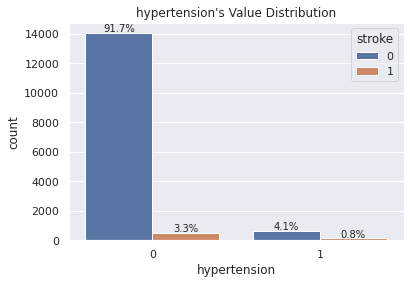

25.40812720848057 4.409090909090908


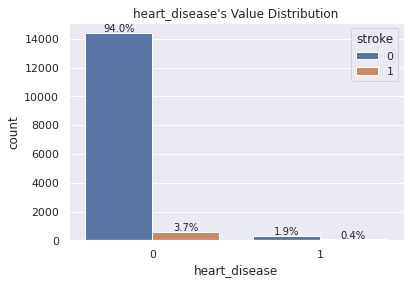

23.253968253968253 23.176656151419557


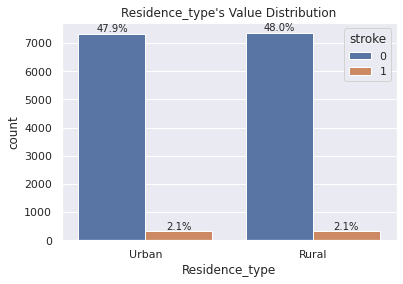

16.57191201353638 118.97560975609757


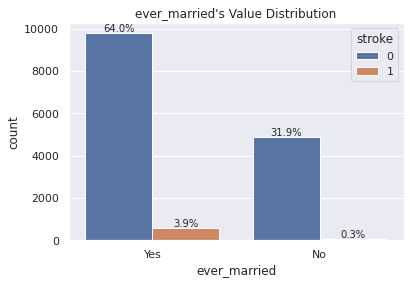

In [ ]:
# 이진형 데이터별 
for cat_col_v1 in cat_cols_v1:
  ax = sns.countplot( data=train, x=cat_col_v1, hue='stroke');
  show_text_percent_by_stroke( ax, train.shape[0] )
  ax.set_title(f'{cat_col_v1}\'s Value Distribution')
  plt.show()
  
# 고혈압 : 뇌졸중 환자 중 고혈압 환자의 비율은 낮음 
# 심장질환 : 뇌졸중 환자 중 심장질환 환자의 비율은 낮음
# 거주지역 : 도시, 시골 비율 거의 동일함 => 해당 부분으로는 변별력이 없을 것이라고 예상됨 
# 결혼 : 결혼한 사람들의 비율이 높으며 뇌졸중 환자 중 기혼의 비율이 높음

- 데이터 중 Residence_type과 bmi의 경우 뇌졸중 환자가 아닌 사람과 뇌졸중 환자인 사람들의 분포가 비슷하게 나와서 해당 데이터로는 상관관계를 분석하기에는 무리가 있다고 판단됨

## 데이터 병합

In [ ]:
original_st =  original[original[['stroke']].all(1)]
train = pd.concat((train, original_st))
train.shape

(15553, 11)

In [ ]:
original.info()

In [ ]:
# 'Residence_type', 'bmi' 삭제 => 변별력 무 
# original - bmi 결측치 있었으나 사용하지 않을 항목으로 결측치 보완하지 않고 삭제함
train.drop(['Residence_type', 'bmi'], axis=1, inplace=True)
test.drop(['Residence_type', 'bmi'], axis=1, inplace=True)
original.drop(['Residence_type', 'bmi'], axis=1, inplace=True)

In [ ]:
train.info(), test.info(), original.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15553 entries, 0 to 43424
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             15553 non-null  object 
 1   age                15553 non-null  float64
 2   hypertension       15553 non-null  int64  
 3   heart_disease      15553 non-null  int64  
 4   ever_married       15553 non-null  object 
 5   work_type          15553 non-null  object 
 6   avg_glucose_level  15553 non-null  float64
 7   smoking_status     15553 non-null  object 
 8   stroke             15553 non-null  int64  
dtypes: float64(2), int64(3), object(4)
memory usage: 1.2+ MB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 10204 entries, 15304 to 25507
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             10204 non-null  object 
 1   age                10204 non-null  float6

(None, None, None)

In [ ]:
# 데이터 변환 후, 타입 확인
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15553 entries, 0 to 43424
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             15553 non-null  object 
 1   age                15553 non-null  float64
 2   hypertension       15553 non-null  int64  
 3   heart_disease      15553 non-null  int64  
 4   ever_married       15553 non-null  object 
 5   work_type          15553 non-null  object 
 6   avg_glucose_level  15553 non-null  float64
 7   smoking_status     15553 non-null  object 
 8   stroke             15553 non-null  int64  
dtypes: float64(2), int64(3), object(4)
memory usage: 1.2+ MB


In [ ]:
# 데이터 변환 후, 타입 확인
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10204 entries, 15304 to 25507
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             10204 non-null  object 
 1   age                10204 non-null  float64
 2   hypertension       10204 non-null  int64  
 3   heart_disease      10204 non-null  int64  
 4   ever_married       10204 non-null  object 
 5   work_type          10204 non-null  object 
 6   avg_glucose_level  10204 non-null  float64
 7   smoking_status     10204 non-null  object 
dtypes: float64(2), int64(2), object(4)
memory usage: 717.5+ KB


## 인코딩

### 명목형 데이터 중 문자열로 되어 있는 데이터 수치형으로 변환

- gender 
  - gender의 other를 male로 변환
- smoking_status
  - 비흡연 vs 흡연 => 이진형 형태로 진행
  - smoking_status의 Unknown을 never_smoked로 변환
  - smoking_status의 formerly smoked를 smoked로 변환


In [ ]:
# gender의 other 위치 확인
train[train['gender'].str.contains('Other')]

,gender,age,hypertension,heart_disease,ever_married,work_type,avg_glucose_level,smoking_status,stroke
id,,,,,,,,,
9363,Other,9.0,0,0,No,children,96.04,Unknown,0


In [ ]:
# gender의 other 위치 확인
test[test['gender'].str.contains('Other')]

,gender,age,hypertension,heart_disease,ever_married,work_type,avg_glucose_level,smoking_status
id,,,,,,,,
19933,Other,56.0,0,0,Yes,Private,102.53,Unknown


In [ ]:
# Other 값을 Male로 변경
train.loc[9363, 'gender'] = 'Male'
test.loc[19933, 'gender'] = 'Male'

In [ ]:
train['gender'].unique() 
# 변경된 것 확인완료

array(['Male', 'Female'], dtype=object)

In [ ]:
test['gender'].unique() 
# 변경된 것 확인완료

array(['Female', 'Male'], dtype=object)

In [ ]:
# 데이터 변경 후, 교차 분석표 재확인
cross_tab_v1 = make_cross_tab(train, 'gender') 

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


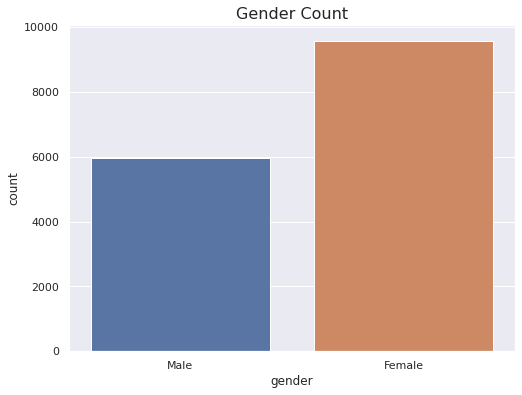

In [ ]:
# 시각화 재확인
plt.figure(figsize=(8, 6))

ax = sns.countplot(train['gender'])
ax.set_title('Gender Count', fontdict={'fontsize': 16})
plt.show()

In [ ]:
# smoking_status에 unknown 확인
train[train['smoking_status'].str.contains('Unknown')]

,gender,age,hypertension,heart_disease,ever_married,work_type,avg_glucose_level,smoking_status,stroke
id,,,,,,,,,
2,Female,42.00,0,0,Yes,Private,103.00,Unknown,0
5,Female,34.00,0,0,Yes,Private,84.35,Unknown,0
7,Male,78.00,0,1,Yes,Self-employed,75.32,Unknown,0
12,Female,4.00,0,0,No,children,84.10,Unknown,0
21,Female,1.72,0,0,No,children,94.12,Unknown,0
...,...,...,...,...,...,...,...,...,...
28493,Male,57.00,0,0,Yes,Private,86.30,Unknown,1
17739,Male,57.00,0,0,Yes,Private,84.96,Unknown,1
49669,Female,14.00,0,0,No,children,57.93,Unknown,1


In [ ]:
# Unknown -> never smoked / 'formerly smoked' -> 'smokes' 변경
train = train.replace({'smoking_status' : 'Unknown'}, 'never smoked')
train = train.replace({'smoking_status' : 'formerly smoked'}, 'smokes')

test = test.replace({'smoking_status' : 'Unknown'}, 'never smoked')
test = test.replace({'smoking_status' : 'formerly smoked'}, 'smokes')

In [ ]:
train['smoking_status'].unique() 
# 변경된 것 확인완료 : train 파일

array(['never smoked', 'smokes'], dtype=object)

In [ ]:
test['smoking_status'].unique() 
# 변경된 것 확인완료 : test 파일

array(['never smoked', 'smokes'], dtype=object)

In [ ]:
# 데이터 변환 후, 교차분석표 확인 
cross_tab_v3 = make_cross_tab(train, 'smoking_status') 
cross_tab_v3

stroke,smoking_status,0,1
0,never smoked,95.420126,4.579874
1,smokes,91.746516,8.253484


타겟값간 비율 2.3869773519163764


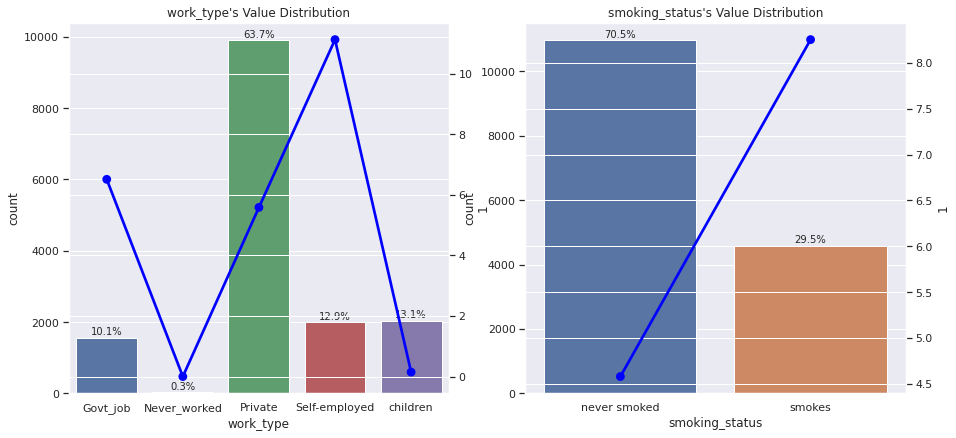

In [ ]:
# 시각화를 통한 재확인 
show_count_point_plot( train, cat_cols_v2)

In [ ]:
# 문자형 데이터를 수치형으로 변경
# train 파일
# gender
train['gender'] = train['gender'].map({
    'Male': 0,
    'Female': 1,
}).astype('int')

# ever_married
train['ever_married'] = train['ever_married'].map({
    'Yes': 1,
    'No': 0
}).astype('int')

# work_type
train['work_type'] = train['work_type'].map({
    'Private':0,
    'Self-employed': 1,
    'Govt_job': 2,
    'children': 3,
    'Never_worked': 4
}).astype('int')

# smoking_status
train['smoking_status'] = train['smoking_status'].map({
    'never smoked' : 0,
    'smokes': 1
}).astype('int')

In [ ]:
# test 파일
# gender
test['gender'] = test['gender'].map({
    'Male': 0,
    'Female': 1,
}).astype('int')

# ever_married
test['ever_married'] = test['ever_married'].map({
    'Yes': 1,
    'No': 0
}).astype('int')

# work_type
test['work_type'] = test['work_type'].map({
    'Private':0,
    'Self-employed': 1,
    'Govt_job': 2,
    'children': 3,
    'Never_worked': 4
}).astype('int')

# smoking_status
test['smoking_status'] = test['smoking_status'].map({
    'never smoked' : 0,
    'smokes': 1
}).astype('int')

In [ ]:
# 변경 후 데이터 확인
train

,gender,age,hypertension,heart_disease,ever_married,work_type,avg_glucose_level,smoking_status,stroke
id,,,,,,,,,
0,0,28.0,0,0,1,0,79.53,0,0
1,0,33.0,0,0,1,0,78.44,1,0
2,1,42.0,0,0,1,0,103.00,0,0
3,0,56.0,0,0,1,0,64.87,0,0
4,1,24.0,0,0,0,0,73.36,0,0
...,...,...,...,...,...,...,...,...,...
17739,0,57.0,0,0,1,0,84.96,0,1
49669,1,14.0,0,0,0,3,57.93,0,1
27153,1,75.0,0,0,1,1,78.80,1,1


In [ ]:
# 변경 후 데이터 확인
test 

,gender,age,hypertension,heart_disease,ever_married,work_type,avg_glucose_level,smoking_status
id,,,,,,,,
15304,1,57.0,0,0,1,0,82.54,0
15305,0,70.0,1,0,1,0,72.06,0
15306,1,5.0,0,0,0,3,103.72,0
15307,1,56.0,0,0,1,2,69.24,1
15308,0,32.0,0,0,1,0,111.15,1
...,...,...,...,...,...,...,...,...
25503,1,27.0,0,0,0,0,75.77,0
25504,0,49.0,0,0,1,0,102.91,0
25505,1,3.0,0,0,0,3,104.04,0


In [ ]:
# 데이터 분리
X=train.drop(['stroke'],axis=1)
y=train['stroke']

X.shape, y.shape

((15553, 8), (15553,))

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((11664, 8), (3889, 8), (11664,), (3889,))

# 피처 스케일링

In [ ]:
train.head().T

id,0,1,2,3,4
gender,0.00,0.00,1.0,0.00,1.00
age,28.00,33.00,42.0,56.00,24.00
hypertension,0.00,0.00,0.0,0.00,0.00
heart_disease,0.00,0.00,0.0,0.00,0.00
ever_married,1.00,1.00,1.0,1.00,0.00
work_type,0.00,0.00,0.0,0.00,0.00
avg_glucose_level,79.53,78.44,103.0,64.87,73.36
smoking_status,0.00,1.00,0.0,0.00,0.00
stroke,0.00,0.00,0.0,0.00,0.00


In [ ]:
# 값의 범위를 맞춰줌
minmax = MinMaxScaler()

X_train_scaled = pd.DataFrame(minmax.fit_transform(X_train),columns=X_train.columns)
X_test_scaled = pd.DataFrame(minmax.fit_transform(X_test),columns=X_test.columns)

In [ ]:
# 상관관계 확인
corr_values = train.corr()
corr_values

,gender,age,hypertension,heart_disease,ever_married,work_type,avg_glucose_level,smoking_status,stroke
gender,1.000000,0.029739,-0.005757,-0.065695,0.037187,-0.079009,-0.041250,-0.044799,-0.019480
age,0.029739,1.000000,0.240904,0.202951,0.711630,-0.431992,0.133673,0.256053,0.299504
hypertension,-0.005757,0.240904,1.000000,0.083803,0.127418,-0.045336,0.141134,0.060199,0.182415
heart_disease,-0.065695,0.202951,0.083803,1.000000,0.088982,-0.035834,0.169438,0.072416,0.157579
ever_married,0.037187,0.711630,0.127418,0.088982,1.000000,-0.403969,0.073649,0.229969,0.125577
work_type,-0.079009,-0.431992,-0.045336,-0.035834,-0.403969,1.000000,-0.028358,-0.188674,-0.053255
avg_glucose_level,-0.041250,0.133673,0.141134,0.169438,0.073649,-0.028358,1.000000,0.063001,0.224479
smoking_status,-0.044799,0.256053,0.060199,0.072416,0.229969,-0.188674,0.063001,1.000000,0.072491
stroke,-0.019480,0.299504,0.182415,0.157579,0.125577,-0.053255,0.224479,0.072491,1.000000


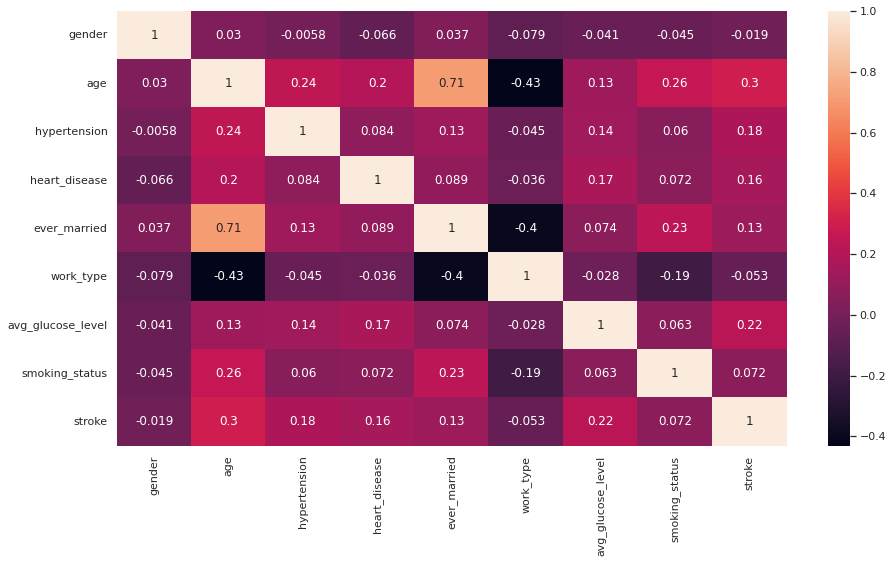

In [ ]:
# 히트맵
sns.set(rc = {'figure.figsize':(15,8)})
sns.heatmap(corr_values, annot=True)

# 모델 구축

In [ ]:
# 정확도 올려라 = 하이퍼 파라미터 튜닝 + 그리드서치 + CV(교차검증 같이 추가)
clf = LogisticRegression()

# 하이퍼파라미터
clf_params = {
    'C':[0.01, 0.1, 0.1, 1, 10 ],   # 규제강도, 높을수록 강함, -> L1, L2가 적용시 규제 강도를 강화
    'max_iter':[500, 750, 1000],   # 모델 성능을 오리기 위해서 학습의 반복 횟수 제한
    'solver':['liblinear'],        # 과적합 방지용 지표 L1, L2 를 모두 지원 -> 방식
    'random_state':[42],          # 난수 시드
}

# 그리드서치 CV -> 최적 파라미터 획득
clf_model = GridSearchCV(clf, clf_params, scoring='roc_auc', cv=5)

# 훈련
clf_model.fit( X_train, y_train )

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': [0.01, 0.1, 0.1, 1, 10],
                         'max_iter': [500, 750, 1000], 'random_state': [42],
                         'solver': ['liblinear']},
             scoring='roc_auc')

In [ ]:
clf_model.best_params_, clf_model.best_score_

({'C': 1, 'max_iter': 500, 'random_state': 42, 'solver': 'liblinear'},
 0.8891722216492877)

In [ ]:
# 성능테스트 
y_pred_test = clf_model.best_estimator_.predict_proba( X_test )[:, 1]
roc_auc_score(y_test, y_pred_test)

0.8808514374888028

In [ ]:
# GridSearchCV + XGBClassifier

parameters = {'learning_rate': [0.01, 0.05, 0.1, 0.2],
               'n_estimators': [50, 100, 500, 1000],
               'max_depth' : [2, 10, 15, 20],
               'max_leaves': [10, 15, 25, 50]}

xgb_model = xgb.XGBClassifier(seed=1)
xgb_model.fit(X_train, y_train)
y_pred = xgb_model.predict(X_test)

#grid_search = GridSearchCV(xgb_model, param_grid=parameters, n_jobs=-1)
#grid_result = grid_search.fit(X_train, y_train)

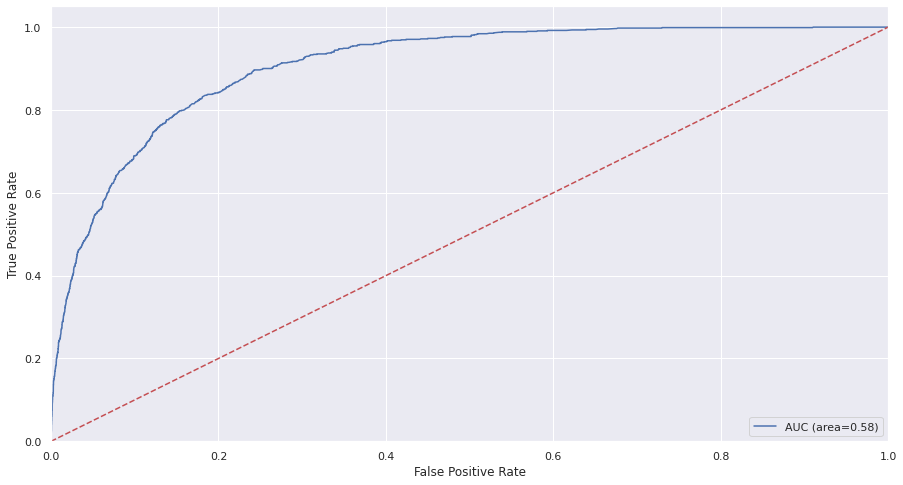

In [ ]:
# 시각화 
roc_auc=roc_auc_score(y,xgb_model.predict(X))
fpr,tpr,thresholds = roc_curve(y,xgb_model.predict_proba(X)[:,1])
plt.figure()
plt.plot(fpr,tpr,label="AUC (area=%0.2f)"%roc_auc)
plt.plot([0,1],[0,1],"r--")
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()

# 예측

In [ ]:
preds = xgb_model.predict_proba(test)[:, 1]
preds

array([0.04903296, 0.27717924, 0.00076654, ..., 0.00076654, 0.00396626,
       0.00046375], dtype=float32)

In [ ]:
preds = minmax.fit_transform(preds.reshape(-1, 1))

In [ ]:
print(xgb_model.score(X_train_scaled, y_train))
print(xgb_model.score(X_test_scaled, y_test))

0.9443587105624143
0.9403445615839547


# 결과

In [ ]:
submission = pd.DataFrame({
    'id': np.arange(15304, 25508),
    'stroke': preds.reshape(-1, )
})
submission.head()

,id,stroke
0,15304,0.052654
1,15305,0.299857
2,15306,0.000356
3,15307,0.035983
4,15308,0.009150


In [ ]:
# 제출 파일 생성 
submission.to_csv('submission_ver5.csv', index=False )